In [1]:
# the ROOT framework 
import ROOT as rt
# load the larcv library
from larcv import larcv
import numpy as np
# load matplotlib for image viewing
import matplotlib.pyplot as plt

from ROOT import std

rt.gSystem.Load("../libssnetdata")

Welcome to JupyROOT 6.14/02


0

In [2]:
# import pytorch and uresnet network
import torch
import uresnet
from uresnet.models.uresnet_dense import UResNet
from uresnet.models.uresnet_dense import SegmentationLoss
from uresnet.flags import URESNET_FLAGS

In [3]:
# Configure network and load it
flags = URESNET_FLAGS()
flags.DATA_DIM = 2
flags.URESNET_FILTERS = 16
flags.URESNET_NUM_STRIDES = 4
flags.SPATIAL_SIZE = 256
flags.NUM_CLASS = 3 # bg, shower, track                                                                                                                                                                     
flags.LEARNING_RATE = 1.0e-3
flags.WEIGHT_DECAY = 1.0e-4
flags.BATCH_SIZE = 16
flags.checkpoint_file = "../checkpoint.run1.11000th.tar" # 16 features, images not conditioned

DEVICE = torch.device("cpu")

# MODEL
model = UResNet(flags).to(DEVICE)

device_map = {"cuda:0":"cpu",
              "cuda:1":"cpu"}
checkpoint = torch.load( flags.checkpoint_file, map_location=device_map )
model.load_state_dict( checkpoint["state"] )
model.eval()
# print model

UResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
    (2): ReLU()
  )
  (double_resnet): ModuleList(
    (0): DoubleResnet(
      (resnet1): ResNetModule(
        (shortcut): Sequential(
          (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
        (residual1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
        (residual2): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
      )
      (resnet2): ResNetModule(
        (shortcut): Sequential(
          (0): Conv2d(32, 32, ker

In [4]:
# LOAD SAMPLES
"""samples.npy  testset_codes.npy  testset_imgs.npy  testset_recons.npy"""
samples  = np.load("../vqvae_samples/samples.npy")
testimg  = np.load("../vqvae_samples/testset_imgs.npy")
testreco = np.load("../vqvae_samples/testset_recons.npy")
testcode = np.load("../vqvae_samples/testset_codes.npy")
#print samples.shape
#print testimg.shape
#print testreco.shape
#print testcode.shape

# switch to pytorch form
samples = samples.reshape( (30,1,64,64) )
testimg = testimg.reshape( (30,1,64,64) ).astype(np.float32)
print "sample shape: ",samples.shape,type(samples),samples.dtype
print "testimg shape: ",testimg.shape,type(testimg),testimg.dtype

# condition
samples *= 70.0
samples[ samples<10 ] = 0
samples[ samples>1000 ] = 1000

# test set
testimg *= 70.0
testimg[ testimg<10 ] = 0
testimg[ testimg>1000 ] = 1000

print "samples mean: ",samples[samples>10].mean()
print "testimg mean: ",testimg[testimg>10].mean()

sample shape:  (30, 1, 64, 64) <type 'numpy.ndarray'> float32
testimg shape:  (30, 1, 64, 64) <type 'numpy.ndarray'> float32
samples mean:  134.5933
testimg mean:  159.86226


In [5]:
# run network on SAMPLES
image_t = torch.from_numpy( samples ).to(DEVICE)
with torch.no_grad():
    out_t = model.forward( image_t )
print out_t.shape
# use softmax
score_t = torch.nn.Softmax(dim=1)(out_t)
pred_t = torch.argmax( score_t, dim=1, keepdim=True ).numpy()
print "pred-shape: ",pred_t.shape
# keep scores on interesting pixels
pred_t[ samples<10 ] = 0
score_t = score_t.numpy()

torch.Size([30, 3, 64, 64])
pred-shape:  (30, 1, 64, 64)


In [6]:
# run network on TEST IMAGES
test_image_t = torch.from_numpy( testimg ).to(DEVICE)
print test_image_t.shape
with torch.no_grad():
    test_out_t = model.forward( test_image_t )
print test_out_t.shape
# use softmax
score_test_t = torch.nn.Softmax(dim=1)(test_out_t)
pred_test_t = torch.argmax( score_test_t, dim=1, keepdim=True ).numpy()
print "pred-shape: ",pred_test_t.shape
# keep scores on interesting pixels
pred_test_t[ testimg<10 ] = 0
score_test_t = score_test_t.numpy()

torch.Size([30, 1, 64, 64])
torch.Size([30, 3, 64, 64])
pred-shape:  (30, 1, 64, 64)


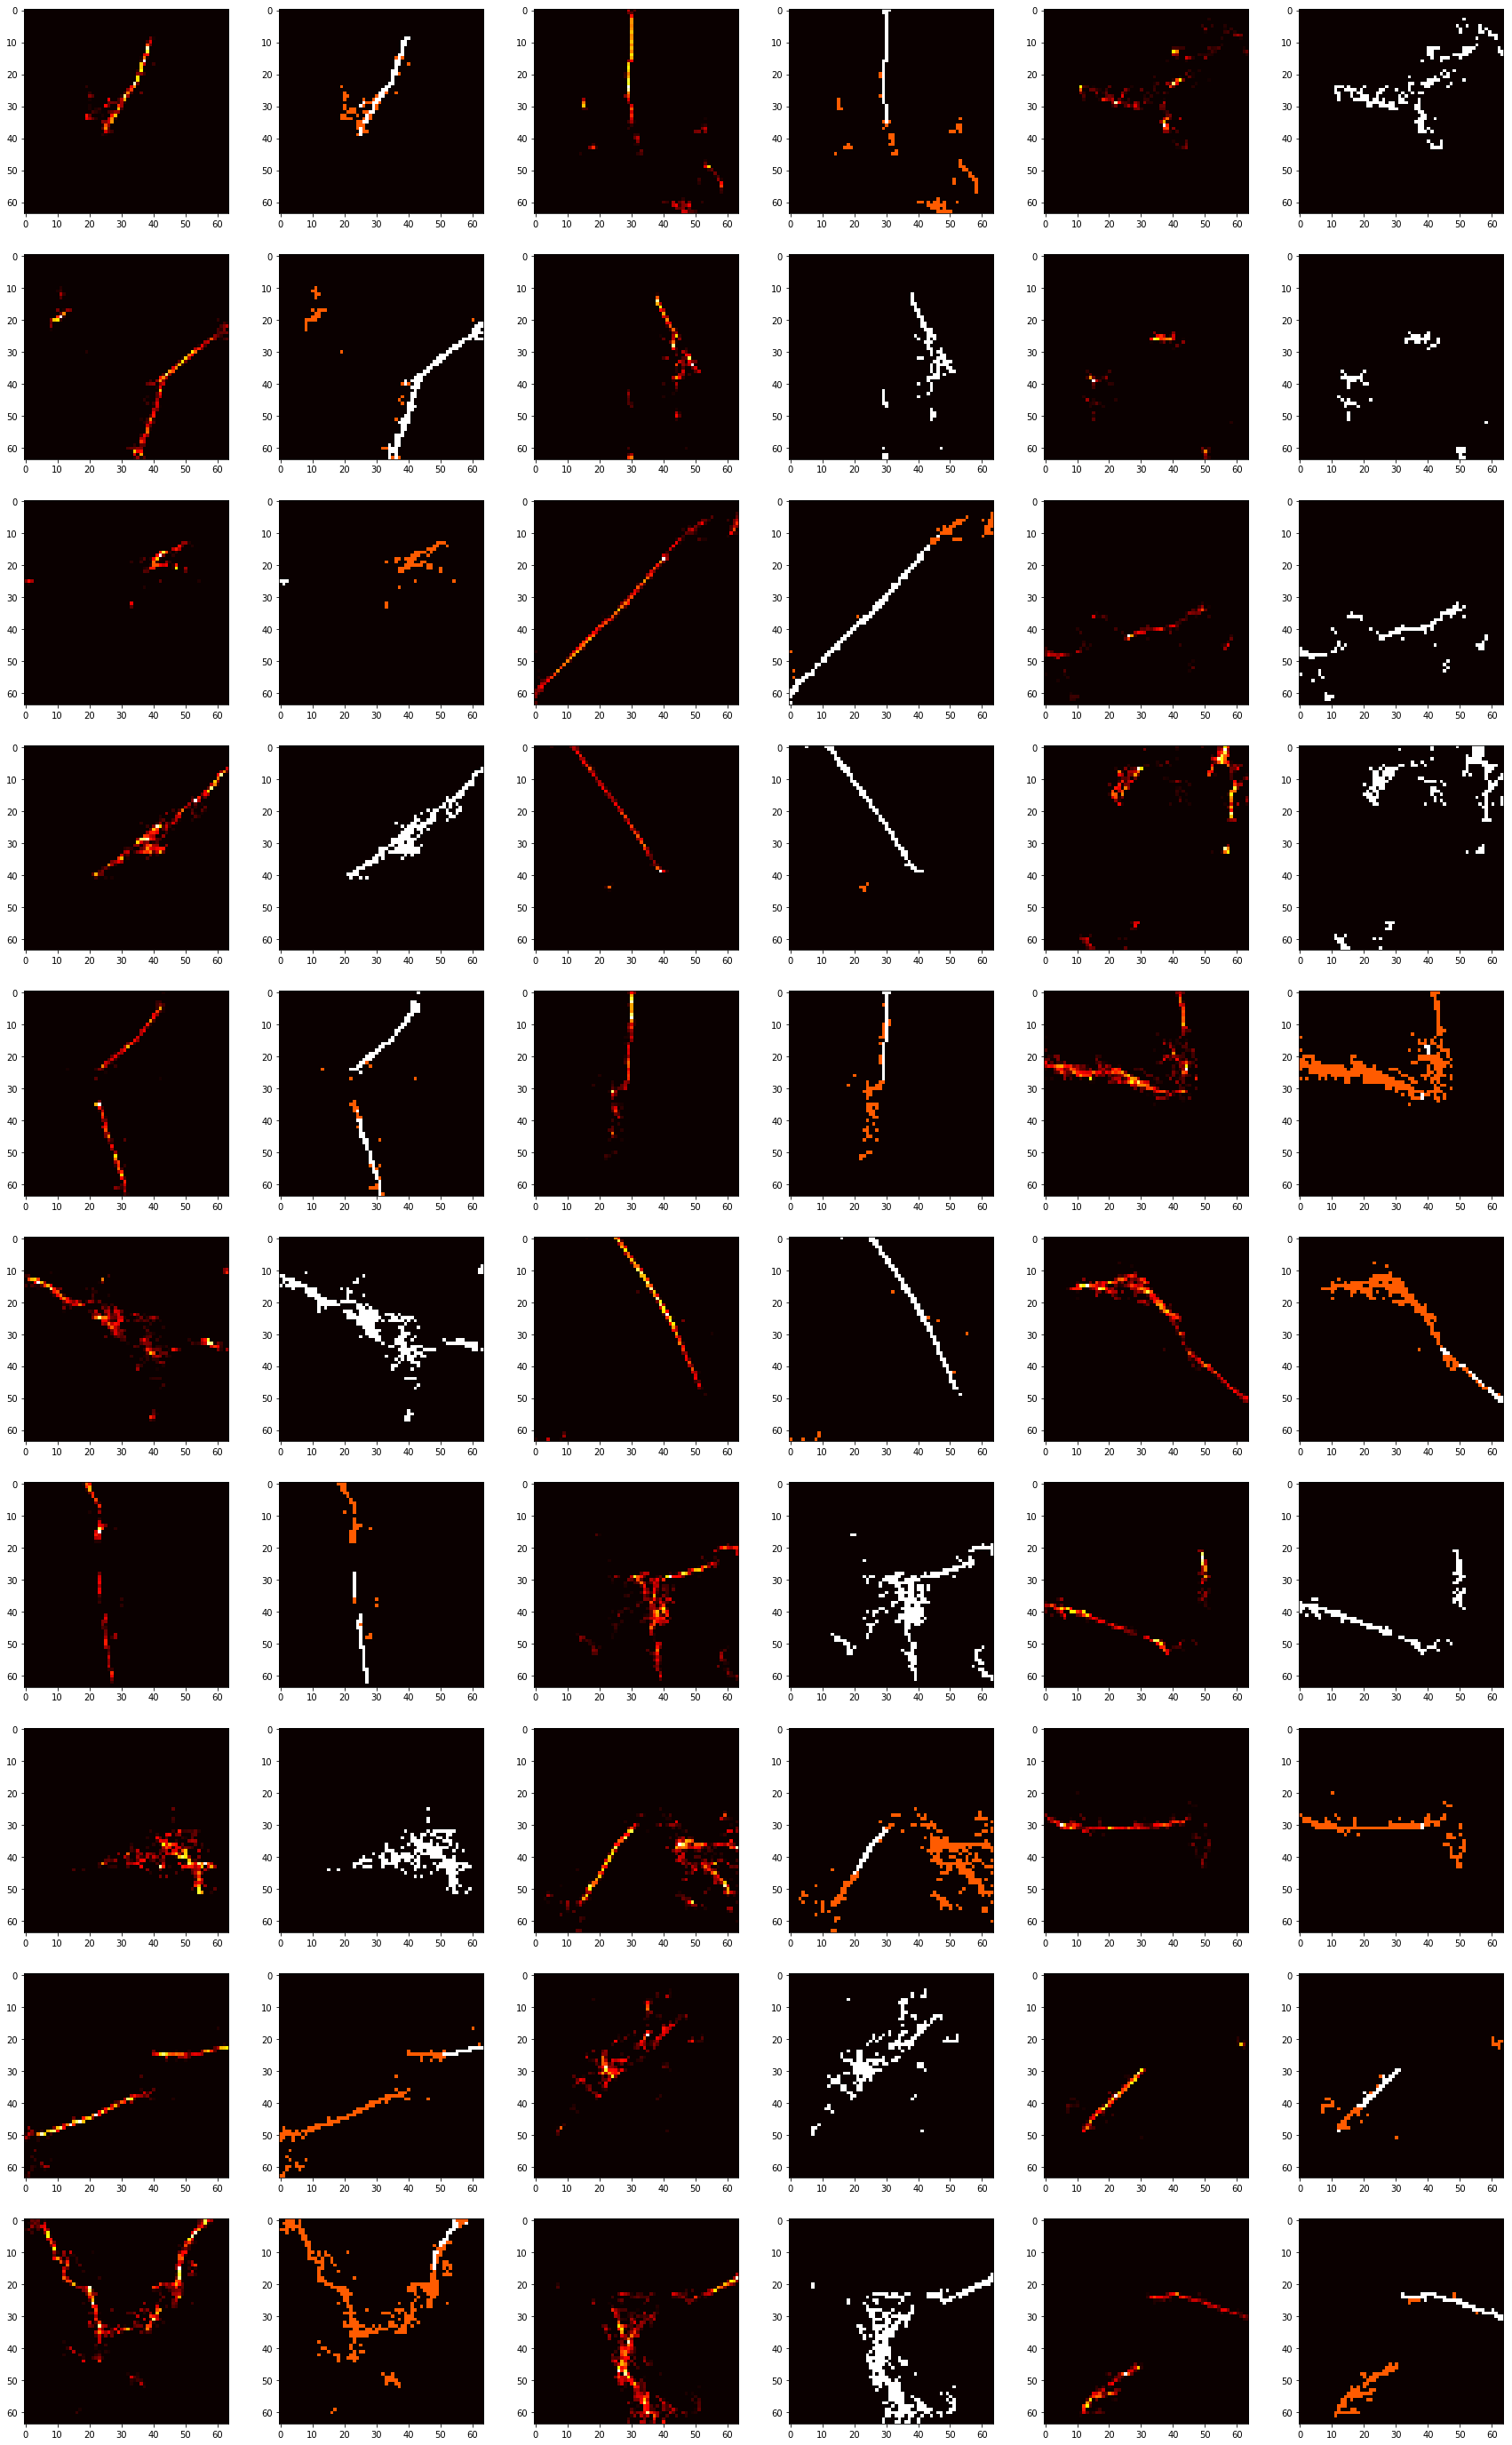

In [49]:
# PRINT SOME SAMPLE IMAGES AND PREDICTIONS
index = np.arange(samples.shape[0])
#np.random.shuffle( index )

fig, ax = plt.subplots(10,6,figsize=(30, 50))
#print index[:9]
for n,idx in enumerate(index): 
    # LEFT: INPUT
    ax[n/3,2*(n%3)].imshow(samples[idx,0,:,:], cmap='hot', interpolation='nearest')
    ax[n/3,2*(n%3)+1].imshow(pred_t[idx,0,:,:], cmap='hot', interpolation='nearest')

fig.show()

[0 1 2 3 4 5 6 7 8]


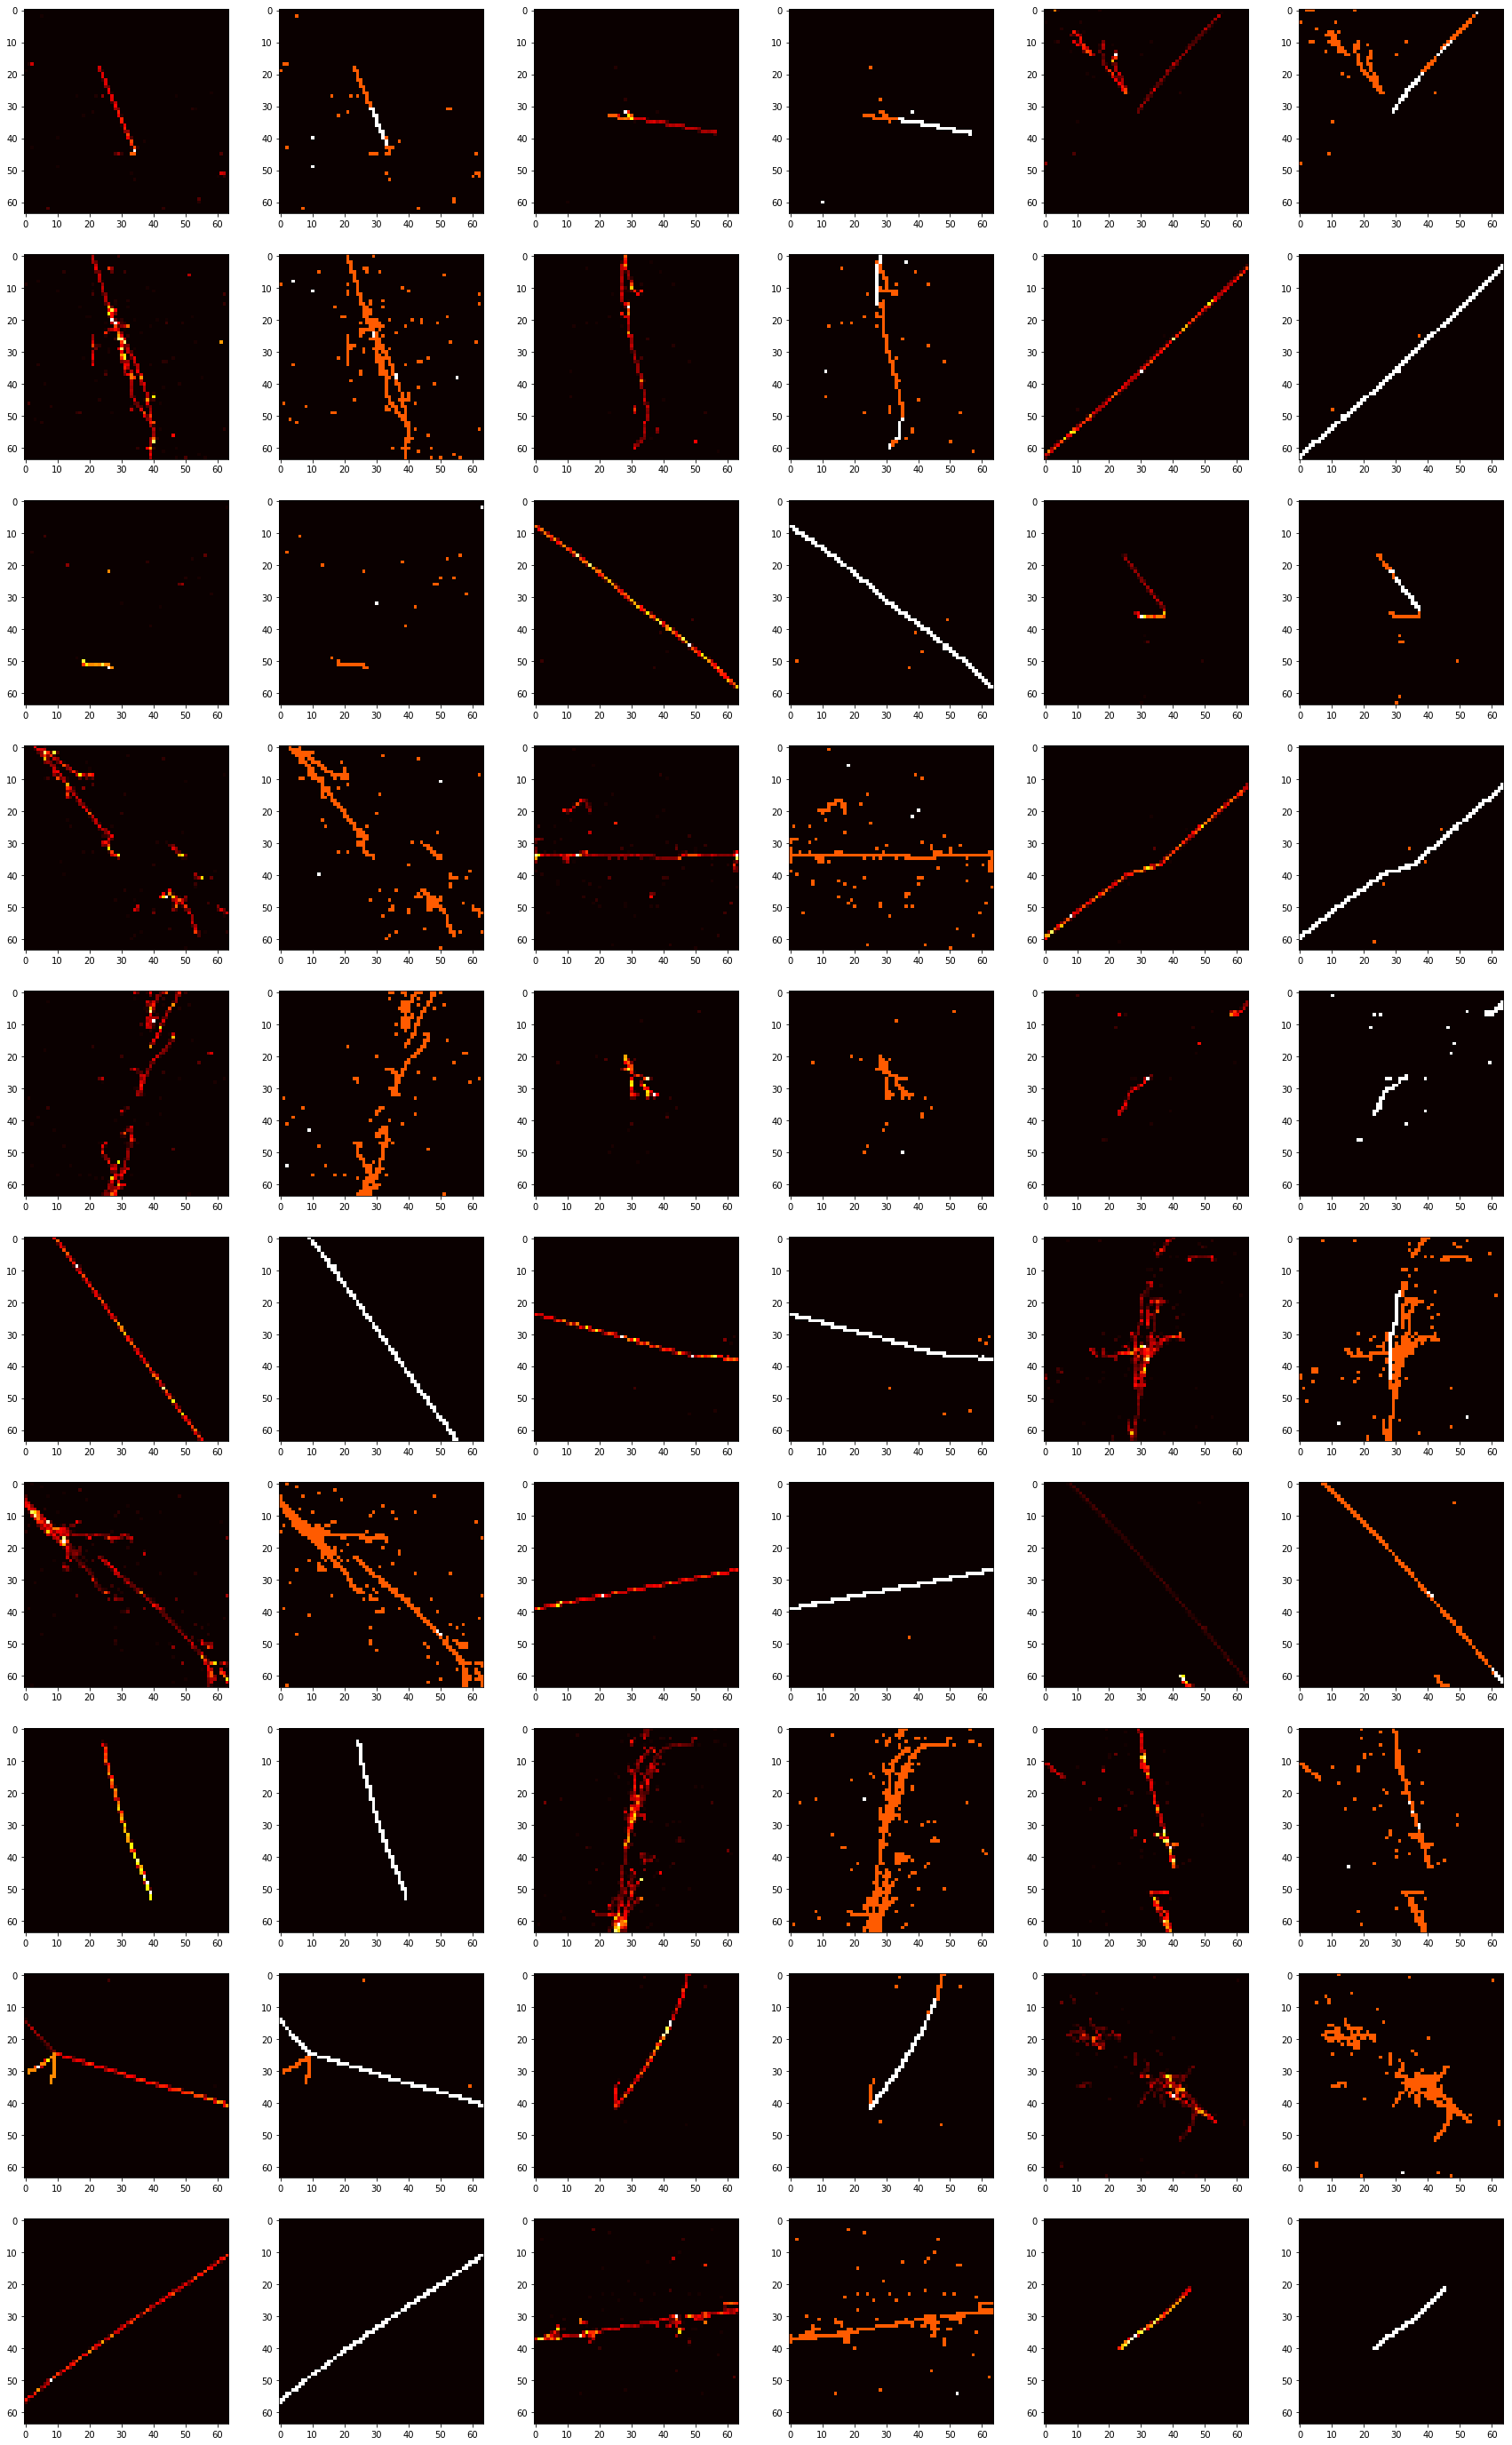

In [47]:
# PRINT SOME TEST IMAGES AND PREDICTIONS
index = np.arange(testimg.shape[0])
#np.random.shuffle( index )

fig, ax = plt.subplots(10,6,figsize=(30, 50))
print index[:9]
for n,idx in enumerate(index): 
    # LEFT: INPUT
    ax[n/3,2*(n%3)].imshow(testimg[idx,0,:,:], cmap='hot', interpolation='nearest')
    ax[n/3,2*(n%3)+1].imshow(pred_test_t[idx,0,:,:], cmap='hot', interpolation='nearest')

fig.show()

In [50]:
# Histograms
import sys
from ROOT import ssnet
filler = ssnet.FillScoreHist()

try:
    hsample_v.clear()
    htest_v.clear()
except:
    pass

hsample_v = std.vector("TH1D")(3)
htest_v   = std.vector("TH1D")(3)

for n,classname in enumerate(["bg","track","shower"]):
    hsample_v[n] = rt.TH1D("hsample_%s"%(classname),"",100,0,1.01)
    htest_v[n] = rt.TH1D("htest_%s"%(classname),"",100,0,1.01)

print "tot images: ",samples.shape[0]
for isample in range(samples.shape[0]):
    score_tensor = score_t[isample,:,:,:]
    print "score tensor (sample) [",isample,"]: ",score_tensor.shape
    filler.fillHist( samples[isample,0,:,:], score_tensor, hsample_v, 10.0 )
    sys.stdout.flush()
    if isample>29:
        break
    
print "tot images: ",testimg.shape[0]
for itest in range(testimg.shape[0]):
    score_test_tensor = score_test_t[itest,:,:,:]
    print "score tensor (test) [",itest,"]: ",score_test_tensor.shape
    filler.fillHist( testimg[itest,0,:,:], score_test_tensor, htest_v, 10.0 )
    sys.stdout.flush()
    if itest>29:
        break
    

tot images:  30
score tensor (sample) [ 0 ]:  (3, 64, 64)
score tensor (sample) [ 1 ]:  (3, 64, 64)
score tensor (sample) [ 2 ]:  (3, 64, 64)
score tensor (sample) [ 3 ]:  (3, 64, 64)
score tensor (sample) [ 4 ]:  (3, 64, 64)
score tensor (sample) [ 5 ]:  (3, 64, 64)
score tensor (sample) [ 6 ]:  (3, 64, 64)
score tensor (sample) [ 7 ]:  (3, 64, 64)
score tensor (sample) [ 8 ]:  (3, 64, 64)
score tensor (sample) [ 9 ]:  (3, 64, 64)
score tensor (sample) [ 10 ]:  (3, 64, 64)
score tensor (sample) [ 11 ]:  (3, 64, 64)
score tensor (sample) [ 12 ]:  (3, 64, 64)
score tensor (sample) [ 13 ]:  (3, 64, 64)
score tensor (sample) [ 14 ]:  (3, 64, 64)
score tensor (sample) [ 15 ]:  (3, 64, 64)
score tensor (sample) [ 16 ]:  (3, 64, 64)
score tensor (sample) [ 17 ]:  (3, 64, 64)
score tensor (sample) [ 18 ]:  (3, 64, 64)
score tensor (sample) [ 19 ]:  (3, 64, 64)
score tensor (sample) [ 20 ]:  (3, 64, 64)
score tensor (sample) [ 21 ]:  (3, 64, 64)
score tensor (sample) [ 22 ]:  (3, 64, 64)
score

sample total:  4737.0
test-img total:  4189.0


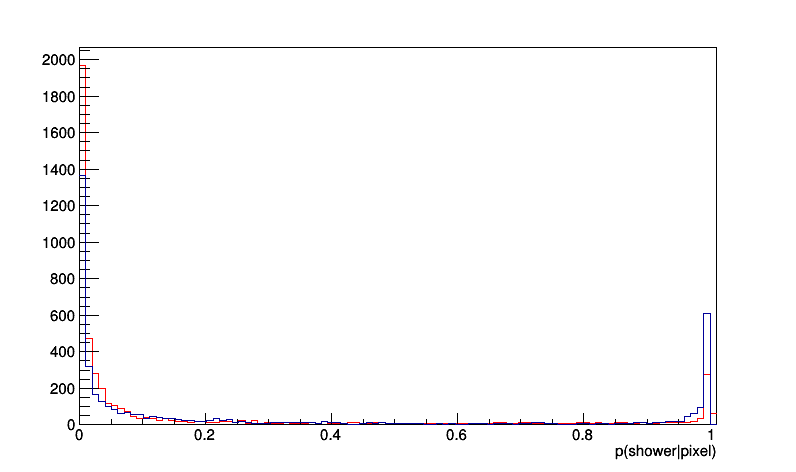

In [51]:
rt.gStyle.SetOptStat(0)
c = {}
c["shower"] = rt.TCanvas("cshower","",800,500)

hshower_tot = hsample_v[2].Integral()
hsample_v[2].SetLineColor( rt.kRed )
#hsample_v[2].Scale( 1.0/hshower_tot )
hsample_v[2].SetTitle(";p(shower|pixel);")
hsample_v[2].Draw("hist")

hshower_test_tot = htest_v[2].Integral()
#htest_v[2].Scale( 1.0/hshower_test_tot )
htest_v[2].Draw("histsame")
c["shower"].Draw()
c["shower"].Update()

print "sample total: ",hshower_tot
print "test-img total: ",hshower_test_tot

sample total:  4737.0
test-img total:  4189.0


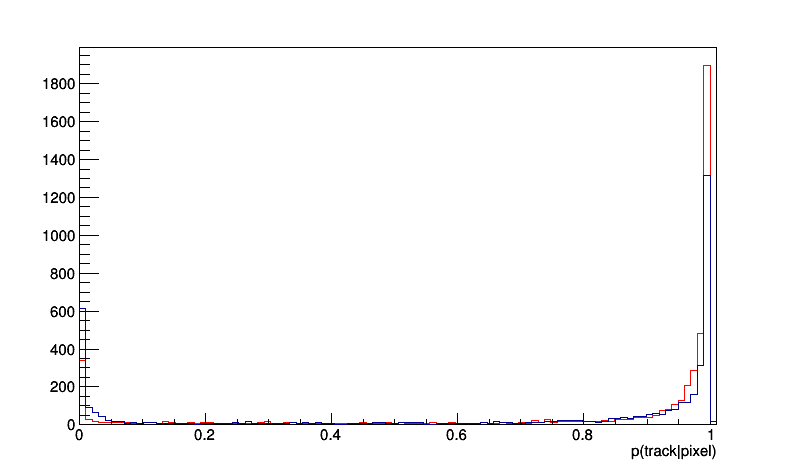

In [52]:
rt.gStyle.SetOptStat(0)
c = {}
c["track"] = rt.TCanvas("ctrack","",800,500)

htrack_tot = hsample_v[1].Integral()
hsample_v[1].SetLineColor( rt.kRed )
#hsample_v[1].Scale( 1.0/htrack_tot )
hsample_v[1].SetTitle(";p(track|pixel);")
hsample_v[1].Draw("hist")

htrack_test_tot = htest_v[1].Integral()
#htest_v[1].Scale( 1.0/htrack_test_tot )
htest_v[1].Draw("histsame")
c["track"].Draw()
c["track"].Update()

print "sample total: ",htrack_tot
print "test-img total: ",htrack_test_tot